### Import necessary libraries
In this first cell, we import the necessary Python libraries for spatial data manipulation, querying OpenStreetMap (OSM) data, and plotting.

In [1]:
# Import necessary libraries
import overpy
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, LineString, Point
from shapely.ops import unary_union, linemerge
from shapely.validation import make_valid
from shapely.errors import TopologicalError
import matplotlib.pyplot as plt
import networkx as nx
import math
%matplotlib widget

### Helper functions
We define some key helper functions used in processing building geometries and calculating the midpoints of building facades.

In [2]:
# Helper function to close small gaps between lines
def close_small_gaps(line, tolerance=0.0001):
    if line.is_ring:  # Already closed
        return line
    # Check if the start and end points are within the tolerance
    if line.coords[0] != line.coords[-1]:
        start = line.coords[0]
        end = line.coords[-1]
        if LineString([start, end]).length <= tolerance:
            coords = list(line.coords)
            coords[-1] = start
            return LineString(coords)
    return line

# Function to get facade midpoints for each building's polygon
def get_facade_midpoints_per_building(geometry, building_id):
    midpoints = []
    
    # Handle MultiPolygon by iterating over each Polygon
    if geometry.geom_type == 'MultiPolygon':
        for polygon in geometry.geoms:
            exterior_coords = list(polygon.exterior.coords)
            
            # Process each edge of the polygon and compute its midpoint
            for i in range(len(exterior_coords) - 1):
                p1 = exterior_coords[i]
                p2 = exterior_coords[i + 1]
                
                # Create midpoint
                midpoint = Point((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
                
                # Store facade midpoint data
                midpoints.append({
                    'building_id': building_id, 
                    'geometry': midpoint, 
                    'facade_index': i
                })
    # Handle single Polygon
    elif geometry.geom_type == 'Polygon':
        exterior_coords = list(geometry.exterior.coords)
        
        # Process each edge of the polygon and compute its midpoint
        for i in range(len(exterior_coords) - 1):
            p1 = exterior_coords[i]
            p2 = exterior_coords[i + 1]
            
            # Create midpoint
            midpoint = Point((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
            
            # Store facade midpoint data
            midpoints.append({
                'building_id': building_id, 
                'geometry': midpoint, 
                'facade_index': i
            })
    
    return midpoints


# Function to process OSM building elements and extract geometries
def process_building(element):
    outer_ways, inner_ways = [], []  # Initialize as two empty lists
    
    # Process relations
    if isinstance(element, overpy.Relation):
        for member in element.members:
            if isinstance(member, (overpy.Way, overpy.RelationWay)): 
                if member.role == 'outer':
                    outer_ways.append(member)
                elif member.role == 'inner':
                    inner_ways.append(member)

        if not outer_ways:
            return None  # Skip if no outer ways

        outer_polygons, outer_lines = [], []
        for outer_way in outer_ways:
            if isinstance(outer_way, overpy.RelationWay):
                outer_way = outer_way.resolve()

            nodes = [(float(node.lon), float(node.lat)) for node in outer_way.nodes]
            if len(nodes) >= 2:
                line = LineString(nodes)
                outer_lines.append(line)

        try:
            merged_line = linemerge(outer_lines)
            if isinstance(merged_line, LineString):
                merged_line = close_small_gaps(merged_line)
                if merged_line.is_ring:
                    outer_polygon = Polygon(merged_line)
                    if outer_polygon.is_valid:
                        outer_polygons.append(outer_polygon)
                    else:
                        outer_polygon = make_valid(outer_polygon)
                        if outer_polygon.is_valid:
                            outer_polygons.append(outer_polygon)
            elif isinstance(merged_line, MultiPolygon):
                outer_polygons = list(merged_line.geoms)
            else:
                outer_polygons = [Polygon(line) for line in outer_lines if line.is_ring and Polygon(line).is_valid]
        except TopologicalError as e:
            outer_polygons = [Polygon(line) for line in outer_lines if line.is_ring and Polygon(line).is_valid]

        if not outer_polygons:
            return None

        if len(outer_polygons) > 1:
            geometry = max(outer_polygons, key=lambda p: p.area)
        else:
            geometry = outer_polygons[0]

        # Add holes (inner polygons)
        inner_polygons = []
        for inner_way in inner_ways:
            if isinstance(inner_way, overpy.RelationWay):
                inner_way = inner_way.resolve()

            nodes = [(float(node.lon), float(node.lat)) for node in inner_way.nodes]
            if len(nodes) >= 4:
                if nodes[0] != nodes[-1]:
                    nodes.append(nodes[0])
                inner_polygon = Polygon(nodes)
                if inner_polygon.is_valid:
                    inner_polygons.append(inner_polygon)

        try:
            geometry = Polygon(geometry.exterior.coords, holes=[inner.exterior.coords for inner in inner_polygons if geometry.contains(inner)])
        except TopologicalError as e:
            return None

        if not geometry.is_valid:
            geometry = geometry.buffer(0)
            if not geometry.is_valid:
                return None

    # Simple polygons (for ways)
    else:
        nodes = [(float(node.lon), float(node.lat)) for node in element.nodes]
        if len(nodes) >= 4:
            if nodes[0] != nodes[-1]:
                nodes.append(nodes[0])
            try:
                geometry = Polygon(nodes)
                if not geometry.is_valid:
                    geometry = geometry.buffer(0)
                    if not geometry.is_valid:
                        return None
            except TopologicalError as e:
                return None
        else:
            return None

    height = element.tags.get('height')
    levels = element.tags.get('building:levels')
    building_type = element.tags.get('building')
    name = element.tags.get('name')

    if height:
        try:
            height = float(height)
        except ValueError:
            height = None

    return {
        'osm_id': element.id,
        'geometry': geometry,
        'height': height,
        'levels': levels,
        'building_type': building_type,
        'name': name
    }

close_small_gaps: This function ensures that small gaps between lines are closed. It checks whether the start and end of a line are within a given tolerance and closes the gap if necessary.

process_building: Process of all buildings by properly handlying polygons and multypoligons, as well as situations in which in one relation more than one detached building is present.

get_facade_midpoints_per_building: Given a building polygon, this function calculates and returns the midpoints of each facade (edge) of the building.

### Querying OSM Data
We use Overpass API to query OpenStreetMap for building data within a bounding box of interest.

In [3]:
# Query OSM and process building data using bounding box
lat_min, lon_min, lat_max, lon_max = 44.805803,10.328752,44.807306,10.332336

api = overpy.Overpass()

# Modify query to use bounding box (bbox)
query = f"""
[out:json][timeout:180];
(
  way["building"]({lat_min},{lon_min},{lat_max},{lon_max});
  relation["building"]({lat_min},{lon_min},{lat_max},{lon_max});
);
out body;
>;
out skel qt;
"""
result = api.query(query)

buildings = []
for element in result.ways + result.relations:
    if 'building' in element.tags:
        building_data = process_building(element)
        if building_data:
            buildings.append(building_data)


We query building data from OSM using the Overpass API for a specific geographical area defined by latitude and longitude coordinates.

The result includes ways and relations representing buildings.

### Processing Building Data
Now that we have building data, we process the results into a GeoDataFrame and prepare the data for further spatial analysis.

In [4]:
# Create a GeoDataFrame for building footprints
gdf = gpd.GeoDataFrame(buildings, crs="EPSG:4326")

# Filter for valid geometries
gdf = gdf[gdf.geometry.is_valid]

# Reproject to target CRS (EPSG:7791 - RDN2008 / UTM zone 32N)
target_crs = "EPSG:7791"
gdf_projected = gdf.to_crs(target_crs)

# Filter out small buildings (e.g., less than 10 square meters)
min_area = 10  # in square meters
gdf_projected = gdf_projected[gdf_projected.geometry.area > min_area]

In [5]:
gdf_projected

osm_id                                           geometry height  \
0    182136568  POLYGON ((605329.256 4962223.562, 605344.631 4...   None   
1    182136570  POLYGON ((605272.36 4962301.154, 605277.674 49...   None   
2    182136574  POLYGON ((605260.612 4962306.529, 605264.423 4...   None   
3    182136591  POLYGON ((605149.545 4962296.411, 605158.416 4...   None   
4    182136595  POLYGON ((605135.491 4962382.839, 605137.991 4...   None   
..         ...                                                ...    ...   
181    2427080  POLYGON ((605123.12 4962364.469, 605127.555 49...   None   
182    2427082  POLYGON ((605298.885 4962237.254, 605302.882 4...   None   
183    2427083  POLYGON ((605224.053 4962322.842, 605228.427 4...   None   
184    2427090  POLYGON ((605228.602 4962261.47, 605238.601 49...   None   
185    2427096  POLYGON ((605176.416 4962284.35, 605187.421 49...   None   

    levels building_type                     name  
0     None           yes                     None  
1     None           yes                     None  
2     None           yes                     None  
3     None           yes                     None  
4     None           yes                     None  
..     ...           ...                      ...  
181   None           yes                     None  
182   None           yes  Casa Cordero già Piazza  
183   None           yes                     None  
184   None           yes                     None  
185   None           yes                     None  

[183 rows x 6 columns]

<Axes: >

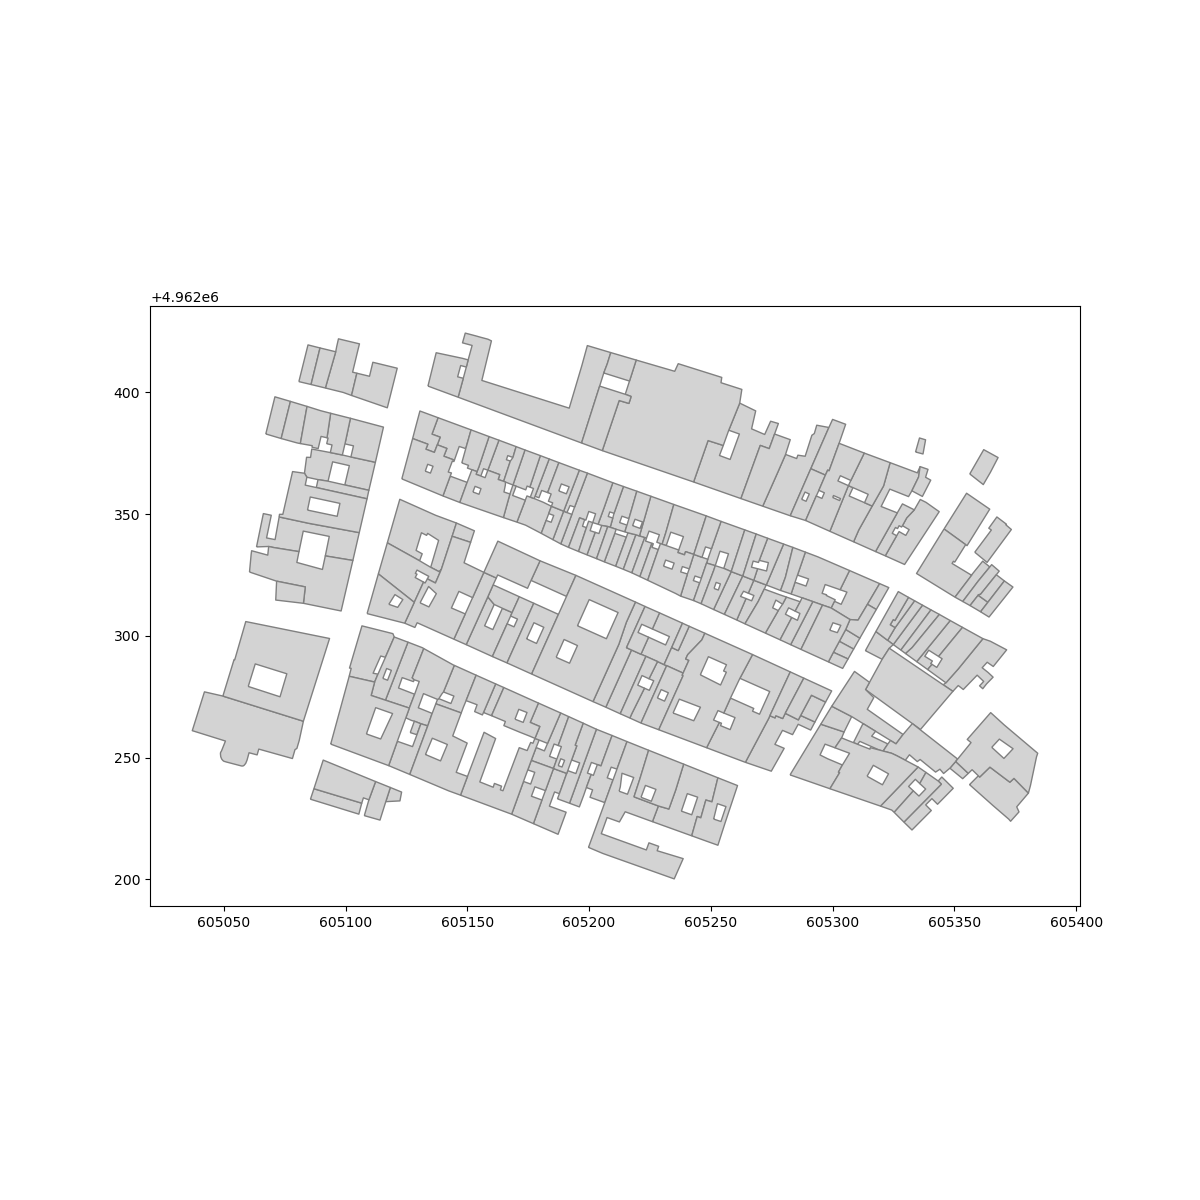

In [6]:
# Plot to verify midpoints per building
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all building footprints in grey
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

We store the building data in a GeoDataFrame.

We reproject the data into the EPSG:7791 coordinate system.

We filter out small buildings with an area of less than 10 square meters.

### Remove buildings that could cause problems
Identify builings and create polygons, remove all buildings intersecting polygons

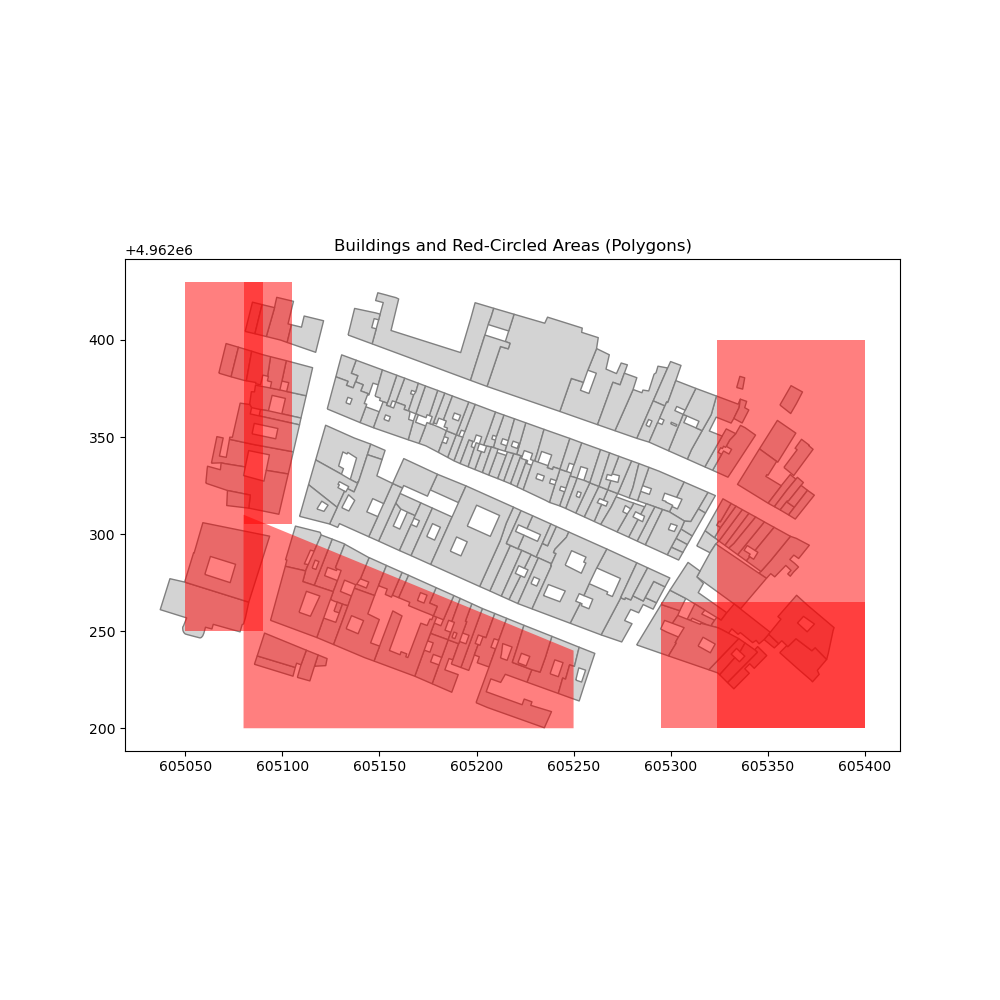

In [7]:
# Example polygons for red-circled areas (replace these with actual coordinates)
polygon_1 = Polygon([(605050, 4962250), (605050, 4962430), (605090, 4962430), (605090, 4962250)])
polygon_2 = Polygon([(605324, 4962200), (605324, 4962400), (605400, 4962400), (605400, 4962200)])
polygon_3 = Polygon([(605080, 4962305), (605080, 4962430), (605105, 4962430), (605105, 4962305)])
polygon_4 = Polygon([(605295, 4962200), (605295, 4962265), (605400, 4962265), (605400, 4962200)])
polygon_5 = Polygon([(605080, 4962200), (605080, 4962310), (605250, 4962240), (605250, 4962200)])

# Create a GeoDataFrame with multiple polygons
gdf_red_circles = gpd.GeoDataFrame(geometry=[polygon_1, polygon_2, polygon_3, polygon_4, polygon_5], crs=gdf_projected.crs)

# Visualize the polygons and the buildings
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original building GeoDataFrame
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot the red-circled areas as polygons
gdf_red_circles.plot(ax=ax, color='red', alpha=0.5)

plt.title("Buildings and Red-Circled Areas (Polygons)")
plt.show()

C:\Users\FedericoBattini\AppData\Local\Temp\ipykernel_24900\3904555827.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_filtered = gdf_projected[~gdf_projected.intersects(gdf_red_circles.unary_union)]


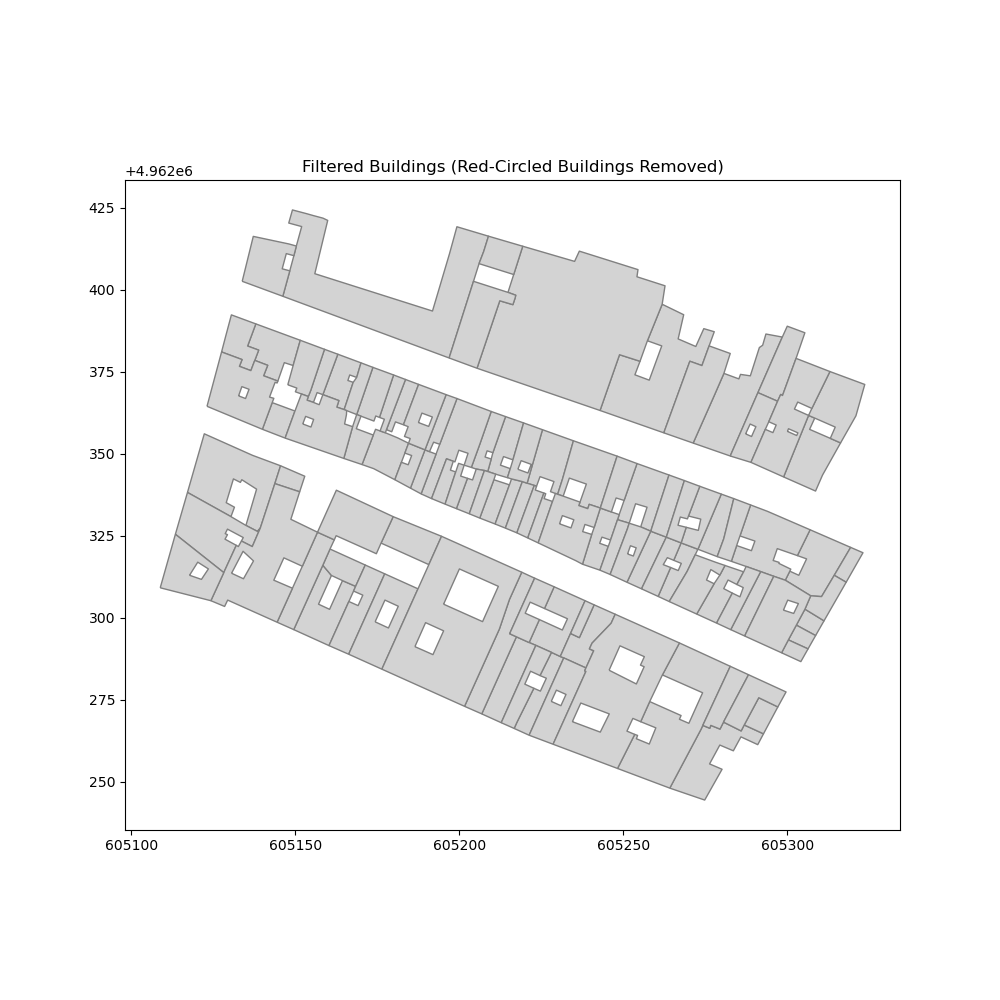

In [8]:
# Perform spatial filtering to remove buildings that intersect with the red-circled areas
gdf_filtered = gdf_projected[~gdf_projected.intersects(gdf_red_circles.unary_union)]

# Visualize the filtered buildings
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the filtered buildings (those that are NOT in the red circles)
gdf_filtered.plot(ax=ax, color='lightgrey', edgecolor='grey')

plt.title("Filtered Buildings (Red-Circled Buildings Removed)")
plt.show()

In [9]:
gdf_projected = gdf_filtered.copy()

### Calculating Facade Midpoints
We calculate the midpoints of the facades for each building.

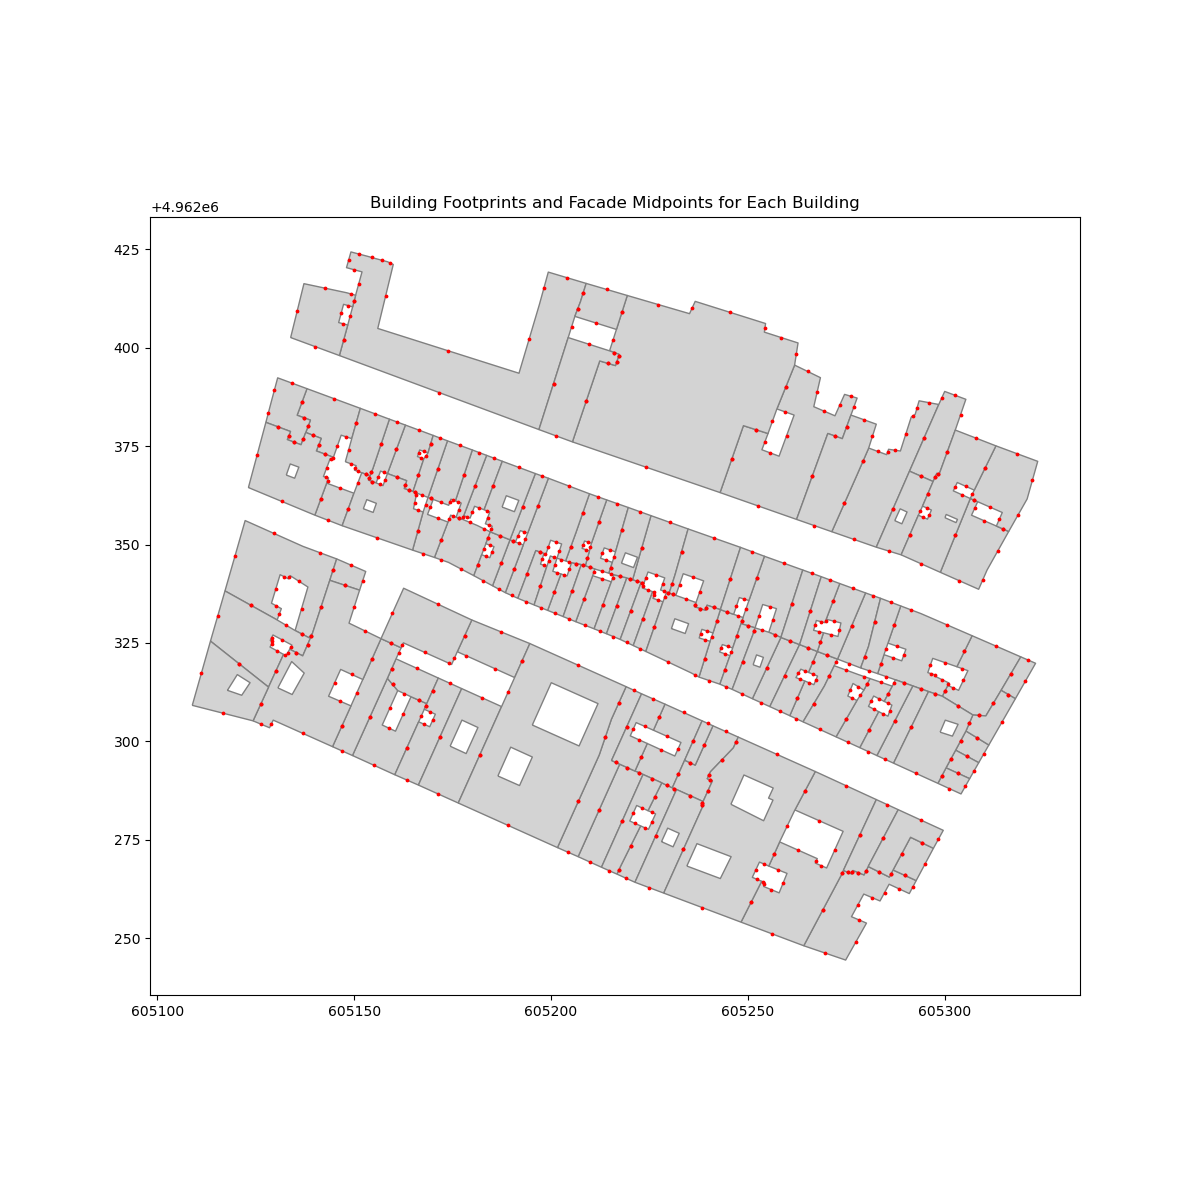

In [10]:
# Process each building footprint separately
facade_midpoints_data = []
for index, row in gdf_projected.iterrows():  # Iterate through rows with index
    building_id = row['osm_id'] if 'osm_id' in gdf_projected.columns else index  # Use OSM ID if available, otherwise use row index
    geometry = row['geometry']
    midpoints = get_facade_midpoints_per_building(geometry, building_id)
    facade_midpoints_data.extend(midpoints)

# Create a GeoDataFrame for facade midpoints
facade_midpoints_gdf = gpd.GeoDataFrame(facade_midpoints_data, crs=gdf_projected.crs)

# Plot to verify midpoints per building
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all building footprints in grey
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot facade midpoints in red
facade_midpoints_gdf.plot(ax=ax, color='red', markersize=3)

plt.title("Building Footprints and Facade Midpoints for Each Building")
plt.show()

This section computes the midpoints of each building facade and stores the results in a new GeoDataFrame.

### Analyzing Grouped Buildings
Here we perform spatial analysis to identify groups of adjacent buildings and find exterior boundaries of these groups.

In [11]:
# Parameters
buffer_distance = 0.1  # For joining buildings
min_segment_length = 1.0  # Minimum length for facade segments

# Use spatial join to find touching buildings
gdf_projected['temp_id'] = gdf_projected.index
gdf_buffered = gdf_projected.copy()
gdf_buffered['geometry'] = gdf_projected.geometry.buffer(buffer_distance)
joined_gdf = gpd.sjoin(gdf_buffered, gdf_buffered, how='inner', predicate='intersects')

# Create the graph from the spatial join results
G = nx.Graph()
for _, row in joined_gdf.iterrows():
    G.add_edge(row['temp_id_left'], row['temp_id_right'])

# Find connected components (groups of adjacent buildings)
connected_components = list(nx.connected_components(G))

# Assign group IDs to buildings based on connected components
gdf_projected['group_id'] = None
for group_id, component in enumerate(connected_components):
    if len(component) == 1:
        gdf_projected.loc[list(component), 'group_id'] = f'standalone_{group_id}'
    else:
        gdf_projected.loc[list(component), 'group_id'] = f'block_{group_id}'

We buffer the buildings slightly to join adjacent buildings and use spatial joins to group them into blocks or groups.

A graph is constructed to represent building adjacency, and connected components (groups) are identified.

### Processing and Plotting Exterior Boundaries and Midpoints
Finally, we plot the exterior boundaries and midpoints of building facades.

In [12]:
gdf_projected

osm_id                                           geometry height  \
1    182136570  POLYGON ((605272.36 4962301.154, 605277.674 49...   None   
2    182136574  POLYGON ((605260.612 4962306.529, 605264.423 4...   None   
3    182136591  POLYGON ((605149.545 4962296.411, 605158.416 4...   None   
4    182136595  POLYGON ((605135.491 4962382.839, 605137.991 4...   None   
5    182136600  POLYGON ((605158.427 4962368.024, 605162.988 4...   None   
..         ...                                                ...    ...   
179    2427076  POLYGON ((605288.902 4962347.382, 605293.278 4...   None   
181    2427080  POLYGON ((605123.12 4962364.469, 605127.555 49...   None   
183    2427083  POLYGON ((605224.053 4962322.842, 605228.427 4...   None   
184    2427090  POLYGON ((605228.602 4962261.47, 605238.601 49...   None   
185    2427096  POLYGON ((605176.416 4962284.35, 605187.421 49...   None   

    levels building_type  name  temp_id group_id  
1     None           yes  None        1  block_0  
2     None           yes  None        2  block_0  
3     None           yes  None        3  block_1  
4     None           yes  None        4  block_0  
5     None           yes  None        5  block_0  
..     ...           ...   ...      ...      ...  
179   None           yes  None      179  block_2  
181   None           yes  None      181  block_0  
183   None           yes  None      183  block_0  
184   None           yes  None      184  block_1  
185   None           yes  None      185  block_1  

[100 rows x 8 columns]

In [13]:
# Process each group and identify facade segments along the outer edge, including building IDs
facade_segments = []
exterior_boundaries = []

for group_id, group_gdf in gdf_projected.groupby('group_id'):
    merged_polygon = unary_union(group_gdf['geometry'])
    polygons = list(merged_polygon.geoms) if merged_polygon.geom_type == 'MultiPolygon' else [merged_polygon]

    for polygon in polygons:
        exterior_boundary = polygon.exterior
        exterior_boundaries.append({'group_id': group_id, 'geometry': exterior_boundary})
        
        for i in range(len(exterior_boundary.coords) - 1):
            p1 = exterior_boundary.coords[i]
            p2 = exterior_boundary.coords[i + 1]
            segment = LineString([p1, p2])
            
            if segment.length >= min_segment_length:
                # Find the closest building to this segment
                closest_building = None
                min_distance = float('inf')
                
                for building_id, building in group_gdf.iterrows():
                    distance = building['geometry'].distance(segment.centroid)  # Find distance to the centroid
                    if distance < min_distance:
                        min_distance = distance
                        closest_building = building_id

                # Assign the closest building to this segment
                if closest_building is not None:
                    midpoint = segment.centroid
                    facade_segments.append({
                        'group_id': group_id, 
                        'building_id': closest_building, 
                        'geometry': midpoint
                    })

# Create GeoDataFrames for facade segments and exterior boundaries
facade_segments_gdf = gpd.GeoDataFrame(facade_segments, crs=gdf_projected.crs)
exterior_boundaries_gdf = gpd.GeoDataFrame(exterior_boundaries, crs=gdf_projected.crs)

For each group of buildings, we compute the exterior boundary and the midpoints of building facades that are part of this boundary.

In [14]:
# Save your data as shapefiles and GeoJSONs
data_path = 'data/Street_view/'

# Save as GeoJSON
gdf_projected.to_file(data_path + "Bologna_buildings.geojson", driver="GeoJSON")
exterior_boundaries_gdf.to_file(data_path + "Bologna_exterior_boundaries.geojson", driver="GeoJSON")
facade_segments_gdf.to_file(data_path + "Bologna_facade_segments.geojson", driver="GeoJSON")


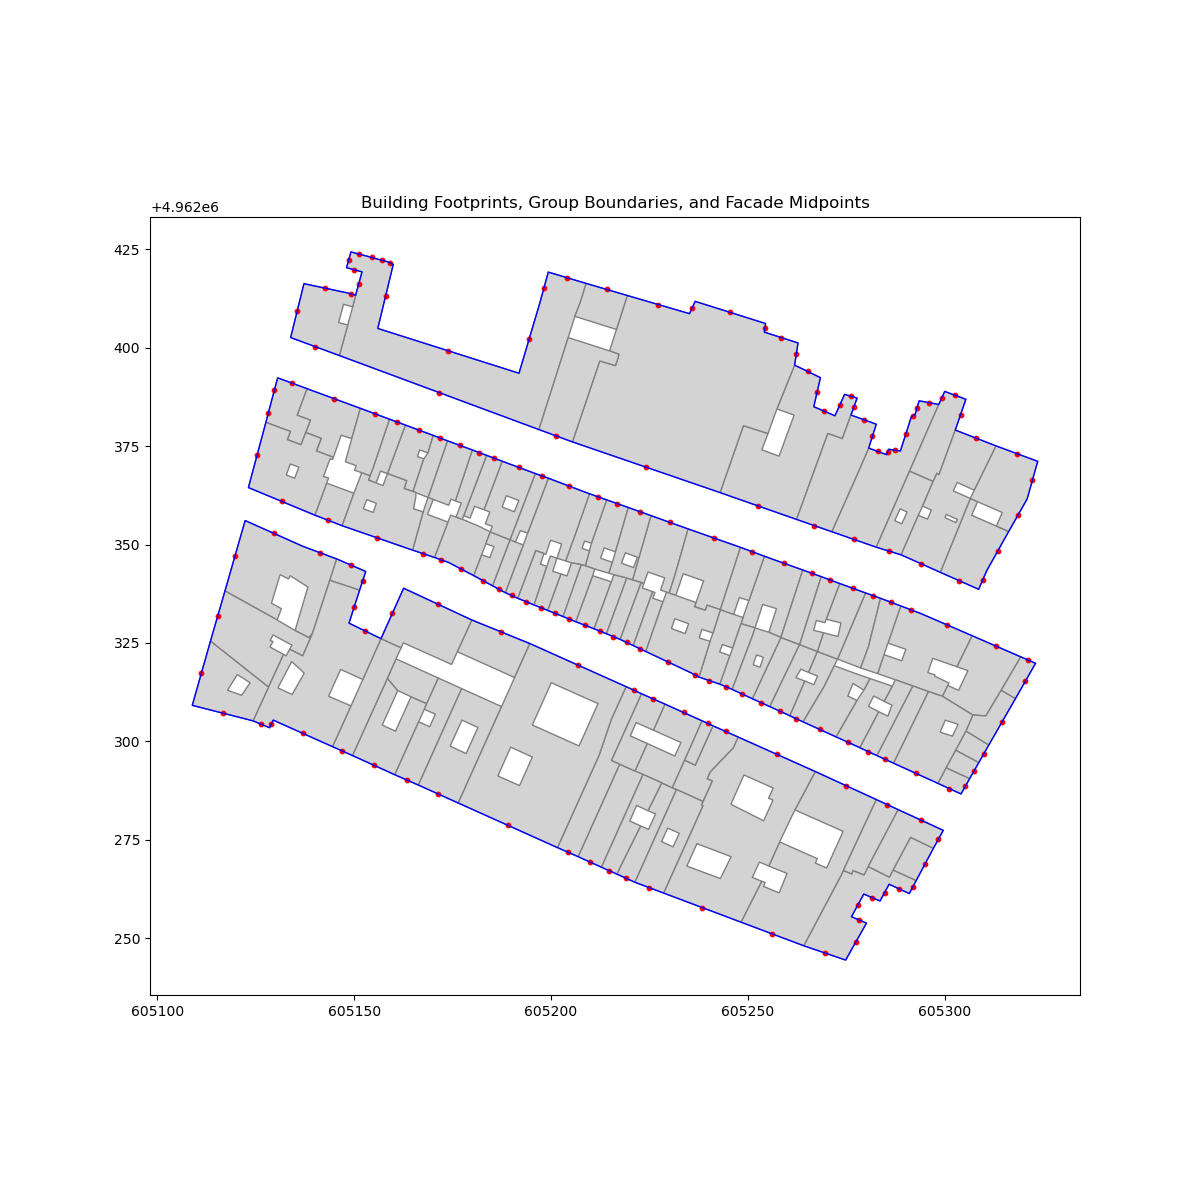

In [15]:
# Plot all buildings, boundaries, and midpoints on one map
fig, ax = plt.subplots(figsize=(12, 12))
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')
exterior_boundaries_gdf.plot(ax=ax, color='blue', linewidth=1)
facade_segments_gdf.plot(ax=ax, color='red', markersize=10)

#cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom=15)
plt.title("Building Footprints, Group Boundaries, and Facade Midpoints")
plt.show()

The final plot shows the buildings, their boundaries, and the calculated facade midpoints.

In [16]:
# Helper function to calculate azimuth between two points
def calculate_azimuth(p1, p2):
    lon1, lat1 = p1
    lon2, lat2 = p2
    # Calculate azimuth as before
    azimuth = math.degrees(math.atan2(lon2 - lon1, lat2 - lat1))
    azimuth = (azimuth + 360) % 360  # Normalize azimuth to [0, 360]

    # Adjust for 90-degree counterclockwise shift
    adjusted_azimuth = (azimuth - 90) % 360

    return adjusted_azimuth


# Function to classify azimuth into cardinal direction with ±45° tolerance
def classify_orientation(azimuth):
    directions = {
        'N': 0,
        'NE': 45,
        'E': 90,
        'SE': 135,
        'S': 180,
        'SW': 225,
        'W': 270,
        'NW': 315
    }
    
    for direction, angle in directions.items():
        if abs(azimuth - angle) <= 45:
            return direction
    return 'N'

# Function to classify azimuth into only N, S, E, W directions with ±45° tolerance
def classify_orientation(azimuth):
    directions = {
        'N': 0,
        'E': 90,
        'S': 180,
        'W': 270
    }
    
    for direction, angle in directions.items():
        if abs(azimuth - angle) <= 45:  # ±45° tolerance for each direction
            return direction
    return 'N'

# Process facade midpoints to assign orientation based on exterior boundaries
def add_orientation_using_exterior_boundaries(facade_segments_gdf, exterior_boundaries_gdf):
    oriented_midpoints = []

    for index, row in facade_segments_gdf.iterrows():
        midpoint = row['geometry']
        group_id = row['group_id']

        # Get the corresponding exterior boundary for this group
        boundary_row = exterior_boundaries_gdf[exterior_boundaries_gdf['group_id'] == group_id]
        if boundary_row.empty:
            continue  # Skip if no matching boundary is found

        boundary = boundary_row.iloc[0]['geometry']  # Get the exterior boundary LINEARRING

        # Iterate over each segment of the exterior boundary
        exterior_coords = list(boundary.coords)
        for i in range(len(exterior_coords) - 1):
            p1 = exterior_coords[i]
            p2 = exterior_coords[i + 1]
            segment = LineString([p1, p2])

            # Check if the midpoint is near the segment (within a small buffer)
            if segment.distance(midpoint) < 1e-6:  # Adjust tolerance as needed
                azimuth = calculate_azimuth(p1, p2)
                orientation = classify_orientation(azimuth)

                # Add the orientation to the midpoint data
                oriented_midpoints.append({
                    'group_id': group_id,
                    'building_id': row['building_id'],
                    'geometry': midpoint,
                    'orientation': orientation
                })
                break  # Once we find the matching segment, we can stop
            
    # Create a new GeoDataFrame with oriented facade midpoints
    oriented_midpoints_gdf = gpd.GeoDataFrame(oriented_midpoints, geometry='geometry', crs=facade_segments_gdf.crs)
    
    return oriented_midpoints_gdf

# Apply the function to classify and add orientation to midpoints based on exterior boundaries
oriented_facade_segments_gdf = add_orientation_using_exterior_boundaries(facade_segments_gdf, exterior_boundaries_gdf)

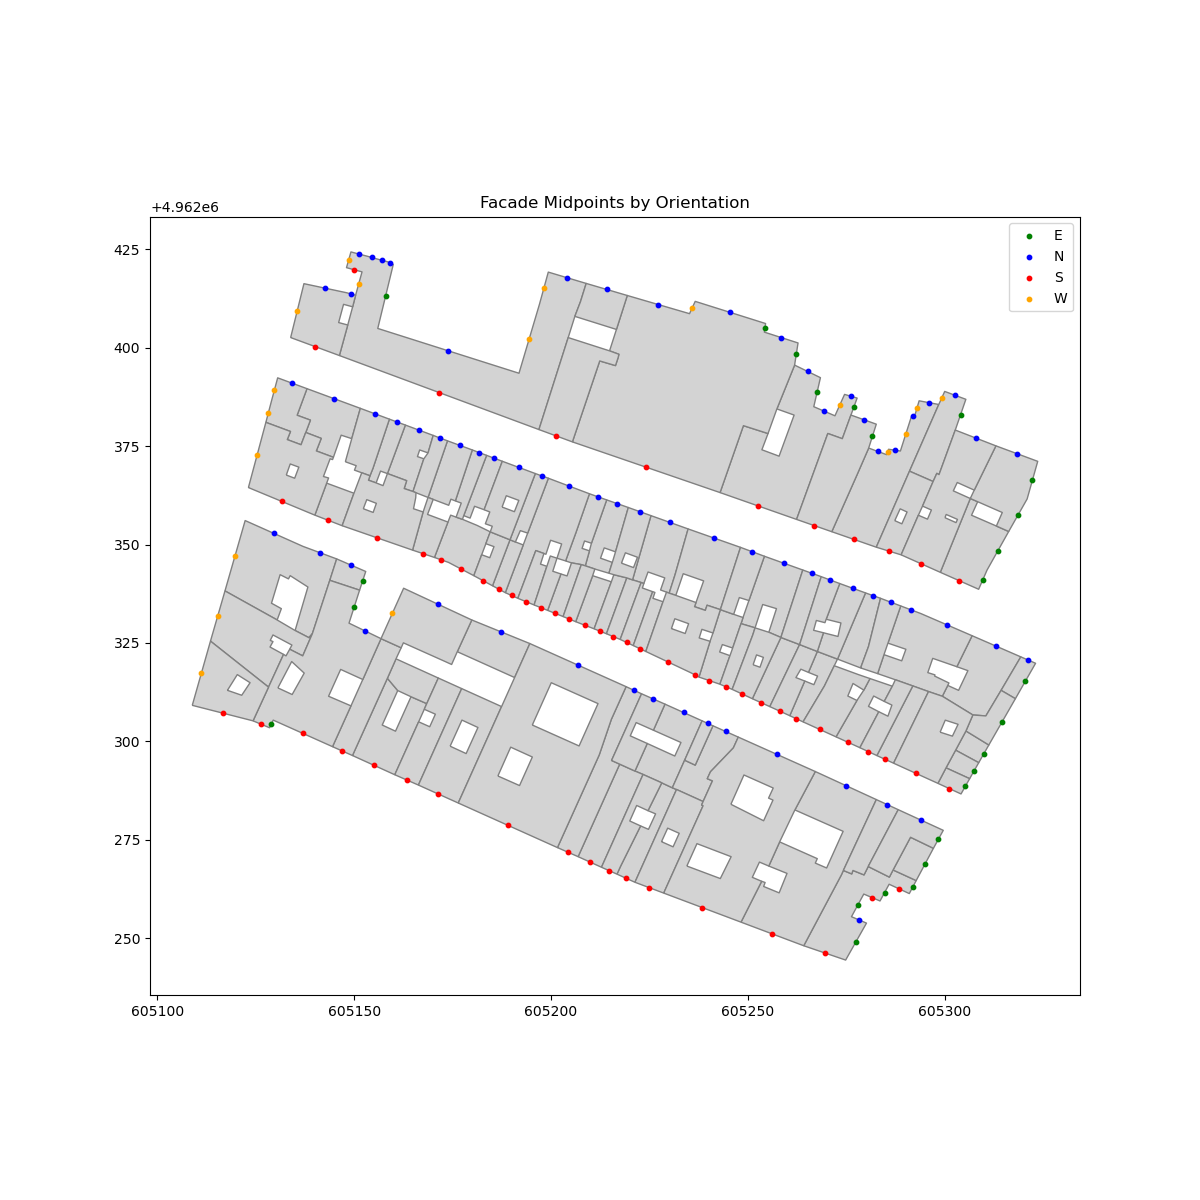

In [17]:
# Plot midpoints grouped by orientation
fig, ax = plt.subplots(figsize=(12, 12))
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot midpoints by orientation, using different colors or markers for each orientation
colors = {'N': 'blue', 'NE': 'cyan', 'E': 'green', 'SE': 'yellow', 'S': 'orange', 'SW': 'red', 'W': 'purple', 'NW': 'pink'}
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}
for orientation, group in oriented_facade_segments_gdf.groupby('orientation'):
    group.plot(ax=ax, color=colors.get(orientation, 'black'), markersize=10, label=orientation)

plt.legend()
plt.title("Facade Midpoints by Orientation")
plt.show()

In [18]:
# Process boundary segments to assign orientation based on exterior boundaries
def add_orientation_to_segments(exterior_boundaries_gdf):
    oriented_segments = []

    for index, row in exterior_boundaries_gdf.iterrows():
        boundary = row['geometry']  # Get the exterior boundary LINEARRING
        group_id = row['group_id']

        # Iterate over each segment of the exterior boundary
        exterior_coords = list(boundary.coords)
        for i in range(len(exterior_coords) - 1):
            p1 = exterior_coords[i]
            p2 = exterior_coords[i + 1]
            segment = LineString([p1, p2])

            # Calculate the azimuth and orientation for the segment
            azimuth = calculate_azimuth(p1, p2)
            orientation = classify_orientation(azimuth)

            # Add the orientation to the boundary segment data
            oriented_segments.append({
                'group_id': group_id,
                'geometry': segment,
                'orientation': orientation
            })

    # Create a new GeoDataFrame with oriented segments
    oriented_segments_gdf = gpd.GeoDataFrame(oriented_segments, geometry='geometry', crs=exterior_boundaries_gdf.crs)
    
    return oriented_segments_gdf

# Apply the function to classify and add orientation to boundary segments
oriented_segments_gdf = add_orientation_to_segments(exterior_boundaries_gdf)

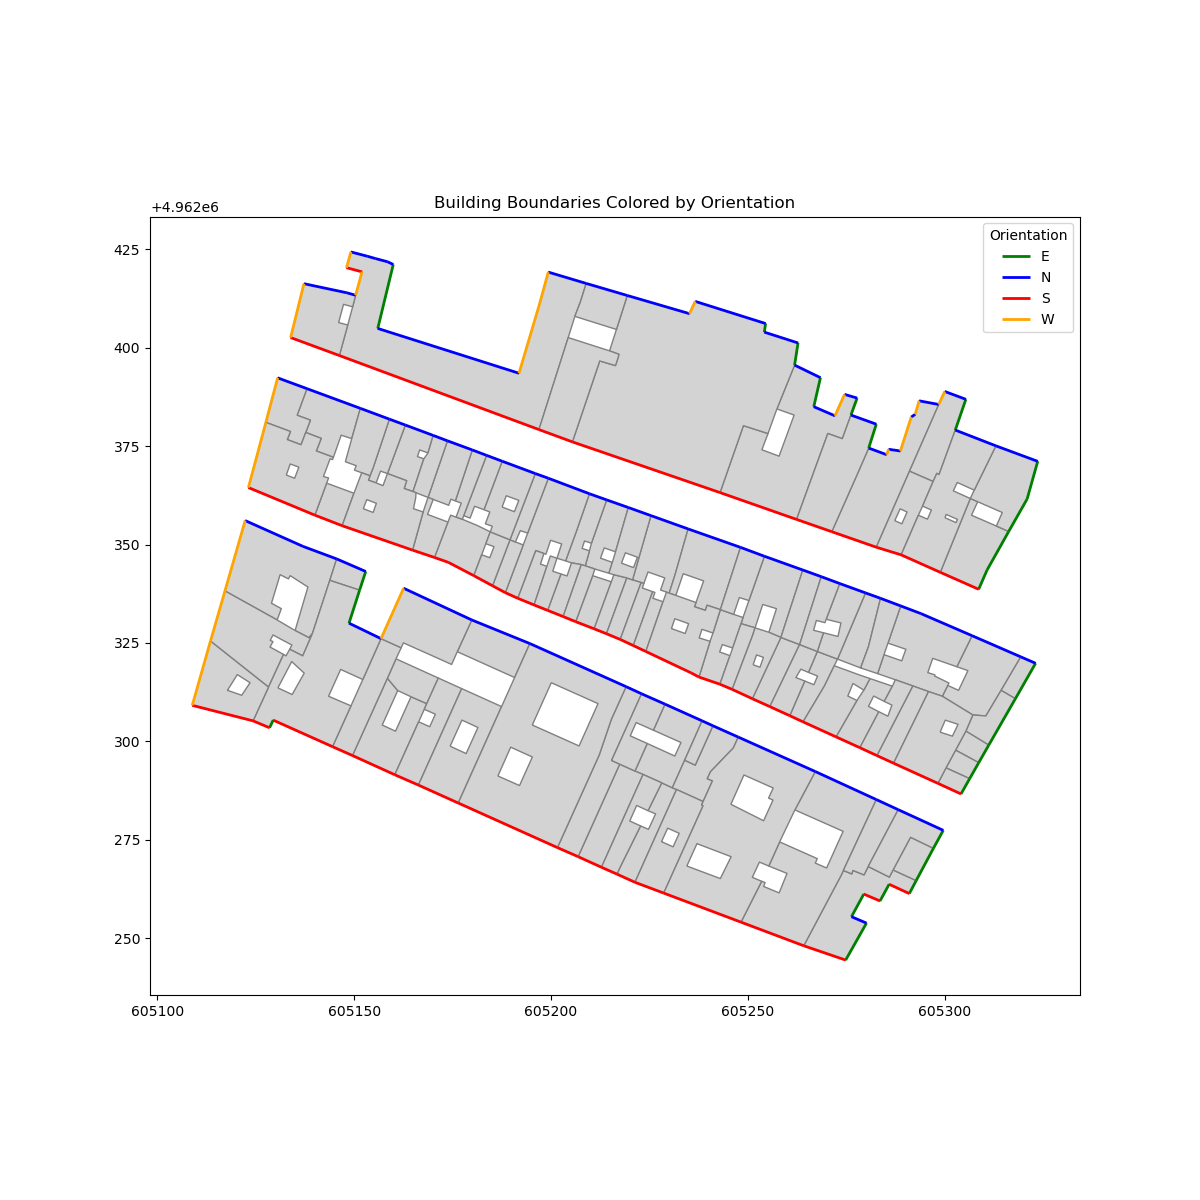

In [19]:
# Plot the segments, coloring by orientation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings or blocks if needed (optional, for context)
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot the oriented segments, color-coded by their orientation
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}
for orientation, group in oriented_segments_gdf.groupby('orientation'):
    group.plot(ax=ax, color=colors[orientation], linewidth=2, label=orientation)

# Add legend
plt.legend(title="Orientation")
plt.title("Building Boundaries Colored by Orientation")
plt.show()

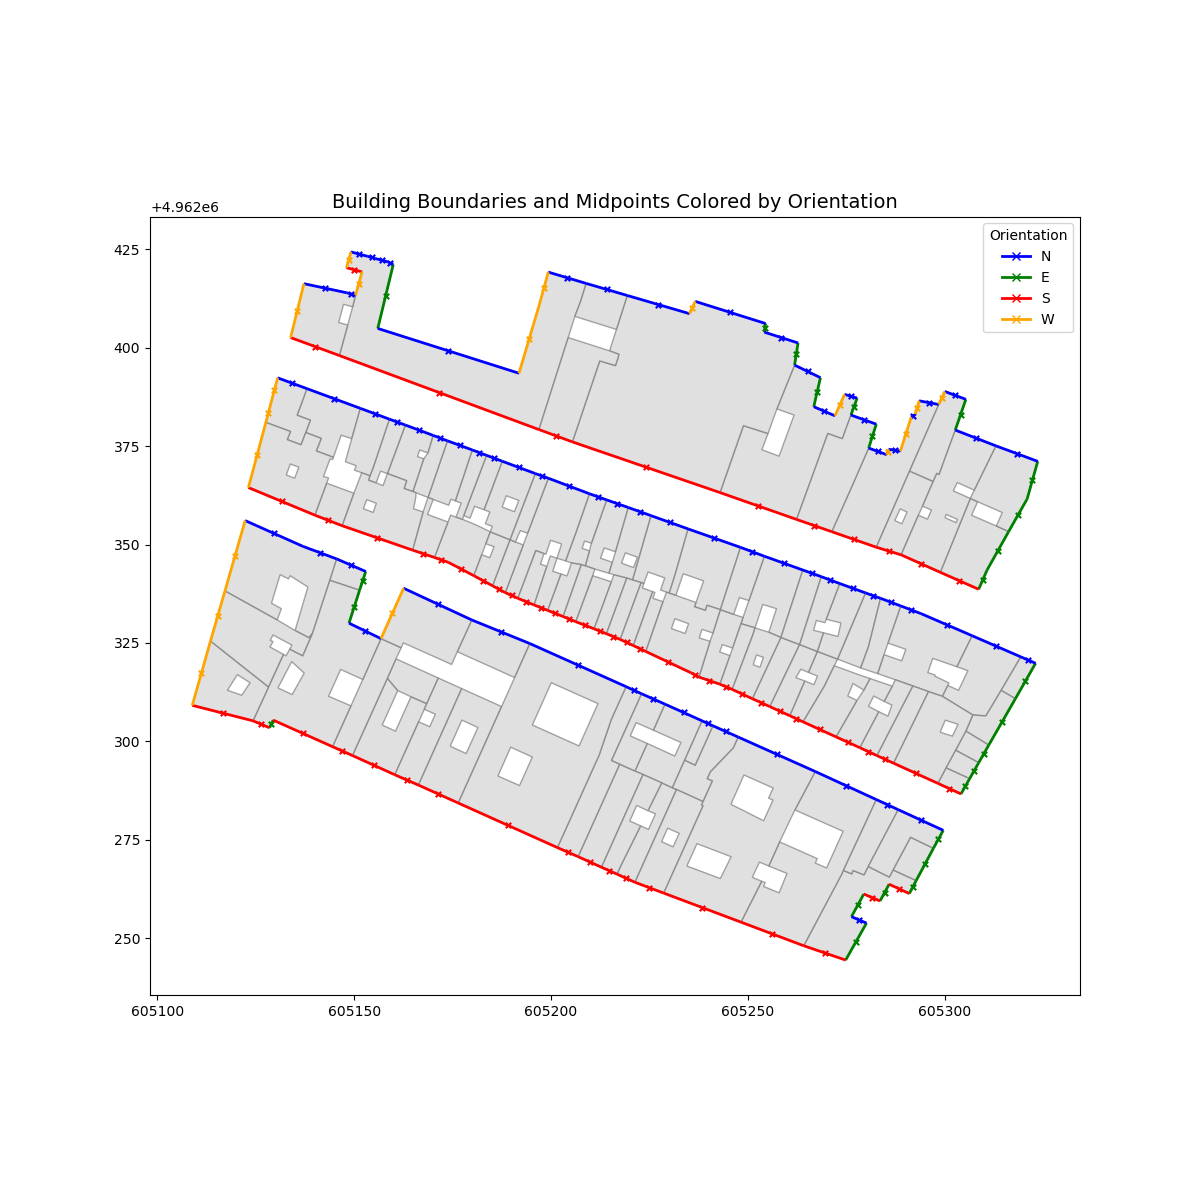

In [20]:
# Plot the segments and midpoints, coloring by orientation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings or blocks for context
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey', alpha=0.7)  # Slight transparency for context

# Define colors for orientations
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}

# Plot the oriented segments (building boundaries) and midpoints together
for orientation, group in oriented_segments_gdf.groupby('orientation'):
    # Plot boundary segments
    group.plot(ax=ax, color=colors[orientation], linewidth=2)
    
    # Plot midpoints with the same color but different marker
    oriented_facade_segments_gdf.groupby('orientation').get_group(orientation).plot(ax=ax, color=colors[orientation], markersize=15, marker='x')

# Add a combined legend only once for both lines and midpoints
legend_labels = [plt.Line2D([0], [0], color=colors[direction], lw=2, marker='x', label=f'{direction}')
                 for direction in colors]
ax.legend(handles=legend_labels, title="Orientation", loc='upper right')

# Improve title and axis display
plt.title("Building Boundaries and Midpoints Colored by Orientation", fontsize=14)

# Show the plot
plt.show()

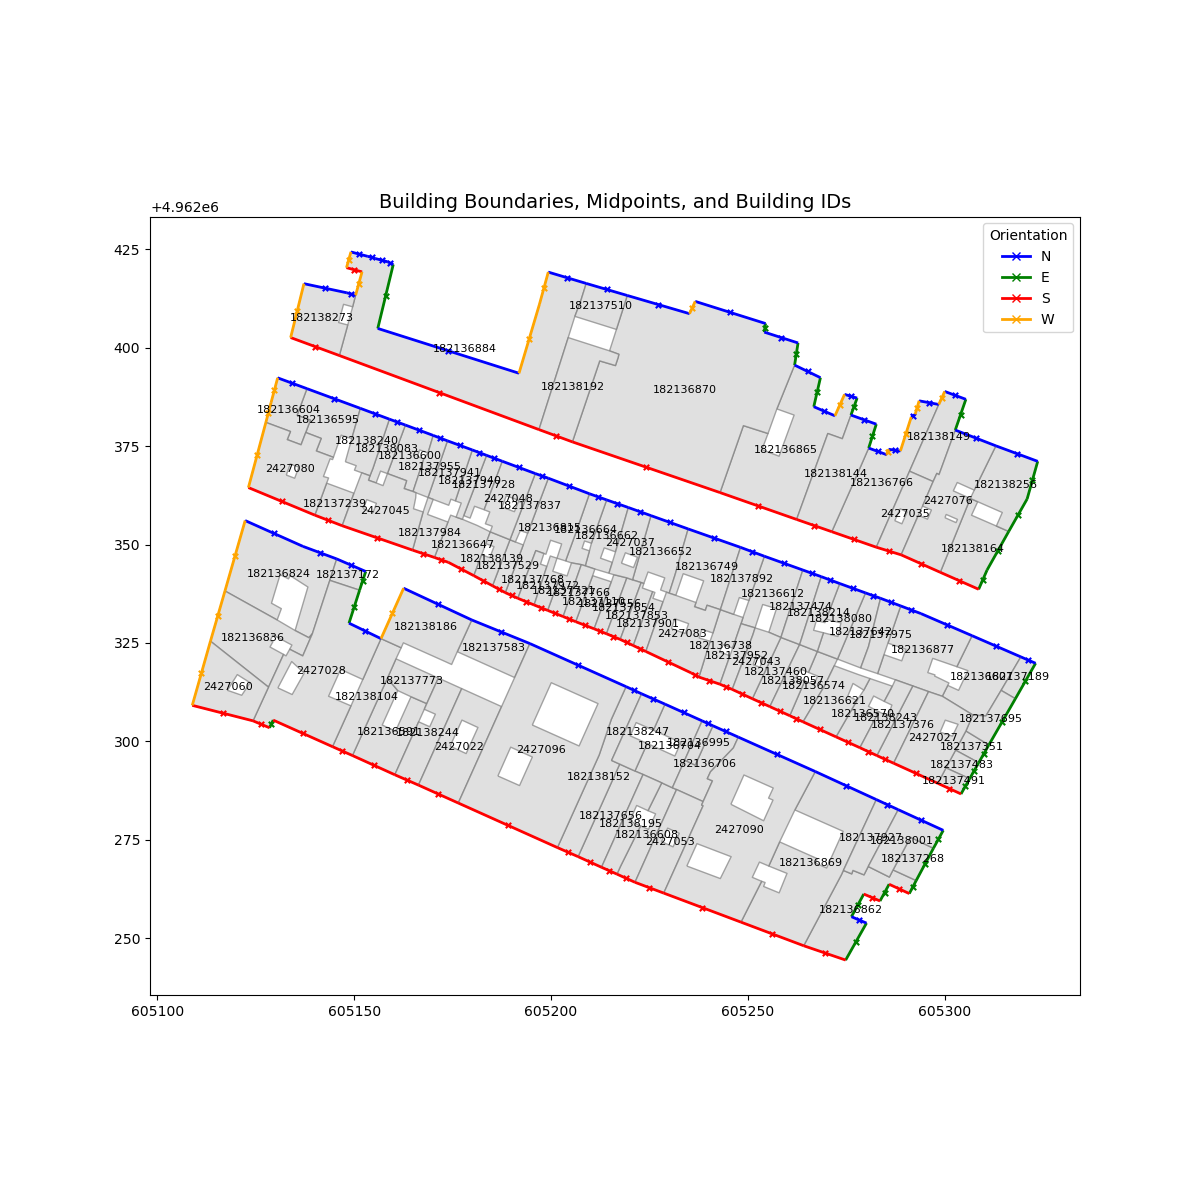

In [21]:
# Plot the segments and midpoints, coloring by orientation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings or blocks for context
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey', alpha=0.7)  # Slight transparency for context

# Define colors for orientations
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}

# Plot the oriented segments (building boundaries) and midpoints together
for orientation, group in oriented_segments_gdf.groupby('orientation'):
    # Plot boundary segments
    group.plot(ax=ax, color=colors[orientation], linewidth=2)
    
    # Plot midpoints with the same color but different marker
    oriented_facade_segments_gdf.groupby('orientation').get_group(orientation).plot(ax=ax, color=colors[orientation], markersize=15, marker='x')

# Add a combined legend only once for both lines and midpoints
legend_labels = [plt.Line2D([0], [0], color=colors[direction], lw=2, marker='x', label=f'{direction}')
                 for direction in colors]
ax.legend(handles=legend_labels, title="Orientation", loc='upper right')

# Plot building IDs on the building shapes using their centroids
for idx, row in gdf_projected.iterrows():  # Assuming gdf_projected has the building geometries
    # Calculate the centroid of the building geometry
    building_centroid = row['geometry'].centroid
    building_id = row['osm_id']  # Assuming the building ID is in 'osm_id'
    
    # Add text labels at the centroid of the building
    ax.text(building_centroid.x, building_centroid.y, str(building_id), fontsize=8, ha='center', va='center', color='black')

# Improve title and axis display
plt.title("Building Boundaries, Midpoints, and Building IDs", fontsize=14)

# Show the plot
plt.show()


In [22]:
from tqdm import tqdm
from shapely.ops import nearest_points

# Ensure that building_id in oriented_facade_segments_gdf matches the index type of gdf_projected
oriented_facade_segments_gdf['building_id'] = oriented_facade_segments_gdf['building_id'].astype(gdf_projected.index.dtype)

# Initialize an empty list to store the final results
matched_rows = []

# Iterate over each unique group_id and track progress using tqdm
for group in tqdm(oriented_facade_segments_gdf['group_id'].unique(), desc="Processing Groups"):
    # Select all midpoints and edges for the current group
    group_midpoints = oriented_facade_segments_gdf[oriented_facade_segments_gdf['group_id'] == group]
    group_edges = oriented_segments_gdf[oriented_segments_gdf['group_id'] == group]
    
    # Iterate over each midpoint in the group
    for idx, midpoint_row in group_midpoints.iterrows():
        midpoint = midpoint_row['geometry']  # Get the midpoint geometry
        
        # Find the closest edge to this midpoint
        closest_edge = None
        min_distance = float('inf')
        for _, edge_row in group_edges.iterrows():
            edge = edge_row['geometry']  # Get the edge geometry
            # Calculate the distance between the midpoint and the edge
            distance = midpoint.distance(edge)
            if distance < min_distance:
                min_distance = distance
                closest_edge = edge_row

        # Get the building details from gdf_projected using building_id
        building_id = midpoint_row['building_id']
        building_info = gdf_projected.loc[building_id]  # Now building_id should match the type of gdf_projected's index

        # Add the matched row (midpoint + closest edge + osm_id) to the result
        matched_rows.append({
            'group_id': group,
            'building_id': building_id,
            'osm_id': building_info['osm_id'],  # Get osm_id from gdf_projected
            'geometry_midpoint': midpoint,
            'orientation_midpoint': midpoint_row['orientation'],
            'geometry_outer_edge': closest_edge['geometry'],
            'orientation_outer_edge': closest_edge['orientation']
        })


Processing Groups: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]


In [23]:
# Create the first GeoDataFrame with geometry_midpoint as the active geometry
gdf_midpoint  = gpd.GeoDataFrame(matched_rows, geometry='geometry_midpoint', crs=oriented_facade_segments_gdf.crs)
# Create the second GeoDataFrame with geometry_outer_edge as the active geometry
gdf_outer_edge  = gpd.GeoDataFrame(matched_rows, geometry='geometry_outer_edge', crs=oriented_facade_segments_gdf.crs)

In [24]:
# keep only S and north orientation
gdf_midpoint = gdf_midpoint[gdf_midpoint['orientation_midpoint'].isin(['S', 'N'])]

In [25]:
gdf_midpoint

group_id  building_id     osm_id               geometry_midpoint  \
0    block_0           34  182136815  POINT (605189.957 4962337.062)   
1    block_0           76  182137529   POINT (605186.74 4962338.654)   
2    block_0          124  182138139  POINT (605182.741 4962340.811)   
3    block_0           12  182136647   POINT (605177.148 4962343.78)   
4    block_0           12  182136647  POINT (605172.146 4962346.093)   
..       ...          ...        ...                             ...   
167  block_2          128  182138164  POINT (605303.719 4962340.791)   
168  block_2          179    2427076  POINT (605293.875 4962345.163)   
169  block_2          165    2427035  POINT (605285.746 4962348.352)   
170  block_2           30  182136766  POINT (605276.937 4962351.292)   
171  block_2          125  182138144   POINT (605266.814 4962354.82)   

    orientation_midpoint                                geometry_outer_edge  \
0                      S  LINESTRING (605191.5512054511 4962336.34351437...   
1                      S  LINESTRING (605188.3636461565 4962337.78027592...   
2                      S  LINESTRING (605185.1156428983 4962339.52716788...   
3                      S  LINESTRING (605180.3671241255 4962342.09397253...   
4                      S  LINESTRING (605173.9284834105 4962345.46647953...   
..                   ...                                                ...   
167                    S  LINESTRING (605308.5914034995 4962338.63759303...   
168                    S  LINESTRING (605298.8467651804 4962342.94473017...   
169                    S  LINESTRING (605288.9022570765 4962347.38194431...   
170                    S  LINESTRING (605282.589834345 4962349.323046219...   
171                    S  LINESTRING (605271.2850887672 4962353.26022057...   

    orientation_outer_edge  
0                        S  
1                        S  
2                        S  
3                        S  
4                        S  
..                     ...  
167                      S  
168                      S  
169                      S  
170                      S  
171                      S  

[129 rows x 7 columns]

In [26]:
import cv2
import numpy as np
import math
import geopandas as gpd
import matplotlib.pyplot as plt

In [27]:
# Find the relevant pictures
gdf = gpd.read_file('data/DEMO_TRACCIATO/RUN.shp')

# Define the values to filter for in the 'RUN' column
run_values = ['116', '117']

# Filter the GeoDataFrame where the 'RUN' column matches any of the values in run_values
gdf_subset = gdf[gdf['RUN'].isin(run_values)]

In [28]:
gdf_subset

X            Y       Z  RUN                    FOTO PATH  \
2515  605331.747  4962326.188  91.764  116  pano_000116_000000.jpg    B   
2516  605331.616  4962326.066  91.762  116  pano_000116_000001.jpg    B   
2517  605328.086  4962325.264  91.799  116  pano_000116_000002.jpg    B   
2518  605324.937  4962326.273  91.848  116  pano_000116_000003.jpg    B   
2519  605322.138  4962327.588  91.850  116  pano_000116_000004.jpg    B   
...          ...          ...     ...  ...                     ...  ...   
2647  605136.254  4962355.894  92.753  117  pano_000117_000061.jpg    B   
2648  605133.434  4962357.041  92.810  117  pano_000117_000062.jpg    B   
2649  605130.624  4962358.199  92.861  117  pano_000117_000063.jpg    B   
2650  605127.830  4962359.382  92.924  117  pano_000117_000064.jpg    B   
2651  605125.086  4962360.586  92.964  117  pano_000117_000065.jpg    B   

      FRAME COMUNE    Heading FRAME_PAD  ANNO     Roll    Pitch       DATA  \
2515      0  PARMA   45.95000      0000  2023  2.13376 -0.76102 2023-11-13   
2516      1  PARMA   48.40613      0001  2023  2.38716 -0.87668 2023-11-13   
2517      2  PARMA   96.72445      0002  2023  1.29739 -2.42945 2023-11-13   
2518      3  PARMA  113.00508      0003  2023  0.23316 -1.15743 2023-11-13   
2519      4  PARMA  115.87231      0004  2023  0.21012 -0.83360 2023-11-13   
...     ...    ...        ...       ...   ...      ...      ...        ...   
2647     61  PARMA  111.87610      0061  2023  0.47016 -1.45724 2023-11-13   
2648     62  PARMA  112.23465      0062  2023  0.09388 -1.36522 2023-11-13   
2649     63  PARMA  112.74831      0063  2023  0.12817 -1.54673 2023-11-13   
2650     64  PARMA  113.50688      0064  2023  0.23950 -1.12233 2023-11-13   
2651     65  PARMA  113.99653      0065  2023  0.30174 -0.96684 2023-11-13   

     STRUMENTO                        geometry  
2515      MX50  POINT (605331.747 4962326.188)  
2516      MX50  POINT (605331.616 4962326.066)  
2517      MX50  POINT (605328.086 4962325.264)  
2518      MX50  POINT (605324.937 4962326.273)  
2519      MX50  POINT (605322.138 4962327.588)  
...        ...                             ...  
2647      MX50  POINT (605136.254 4962355.894)  
2648      MX50  POINT (605133.434 4962357.041)  
2649      MX50  POINT (605130.624 4962358.199)  
2650      MX50   POINT (605127.83 4962359.382)  
2651      MX50  POINT (605125.086 4962360.586)  

[137 rows x 16 columns]

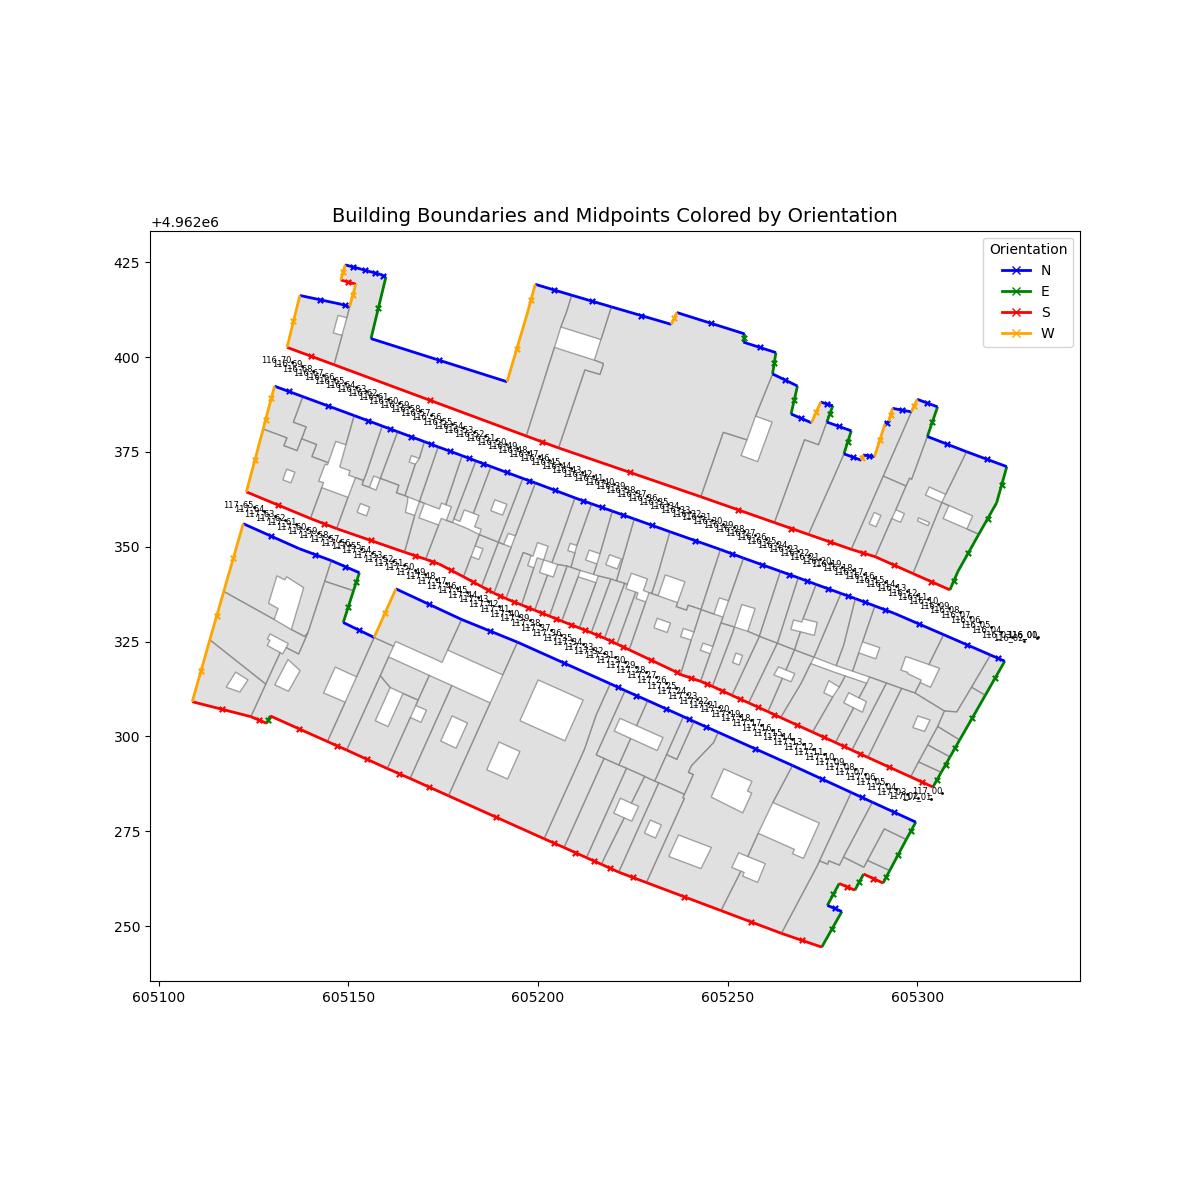

In [29]:
# Plot the segments and midpoints, coloring by orientation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings or blocks for context
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey', alpha=0.7)  # Slight transparency for context

# Define colors for orientations
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}

# Plot the oriented segments (building boundaries) and midpoints together
for orientation, group in oriented_segments_gdf.groupby('orientation'):
    # Plot boundary segments
    group.plot(ax=ax, color=colors[orientation], linewidth=2)
    
    # Plot midpoints with the same color but different marker
    oriented_facade_segments_gdf.groupby('orientation').get_group(orientation).plot(ax=ax, color=colors[orientation], markersize=15, marker='x')

# Add a combined legend only once for both lines and midpoints
legend_labels = [plt.Line2D([0], [0], color=colors[direction], lw=2, marker='x', label=f'{direction}')
                 for direction in colors]
ax.legend(handles=legend_labels, title="Orientation", loc='upper right')

# Plot the subset points and their labels
gdf_subset.plot(ax=ax, color='black', markersize=1)

# Add text labels for points in gdf_subset
for x, y, label in zip(gdf_subset.geometry.x, gdf_subset.geometry.y, gdf_subset['FOTO']):  # Assuming 'name' is the column you want to plot
    ax.text(x, y, label[8:11] + '_' + label[16:18], fontsize=6, ha='right', color='black')

# Improve title and axis display
plt.title("Building Boundaries and Midpoints Colored by Orientation", fontsize=14)

# Show the plot
plt.show()


In [30]:
# Create an empty list to store the results
combined_rows = []

# Iterate over each point in gdf_midpoint
for i, row in gdf_midpoint.iterrows():
    # Get the geometry (point) from gdf_midpoint
    point_gdf_midpoint = row['geometry_midpoint']

    # Calculate the distance from this point to every point in gdf_subset
    distances = gdf_subset.geometry.distance(point_gdf_midpoint)

    # Find the index of the minimum distance (closest point)
    min_distance_index = distances.idxmin()
    min_distance_value = distances.min()

    # Get the closest row from gdf_subset
    closest_row = gdf_subset.loc[min_distance_index]

    # Combine the row from gdf_midpoint and the closest row from gdf_subset
    combined_row = pd.concat([row, closest_row], axis=0)

    # Append the combined row to the results list
    combined_rows.append(combined_row)

# Convert the list of combined rows into a new GeoDataFrame
gdf_combined = pd.DataFrame(combined_rows)

# Convert to GeoDataFrame if needed
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry='geometry_midpoint', crs=gdf_midpoint.crs)

In [31]:
gdf_combined

group_id  building_id     osm_id               geometry_midpoint  \
0    block_0           34  182136815  POINT (605189.957 4962337.062)   
1    block_0           76  182137529   POINT (605186.74 4962338.654)   
2    block_0          124  182138139  POINT (605182.741 4962340.811)   
3    block_0           12  182136647   POINT (605177.148 4962343.78)   
4    block_0           12  182136647  POINT (605172.146 4962346.093)   
..       ...          ...        ...                             ...   
124  block_2          128  182138164  POINT (605303.719 4962340.791)   
125  block_2          179    2427076  POINT (605293.875 4962345.163)   
126  block_2          165    2427035  POINT (605285.746 4962348.352)   
127  block_2           30  182136766  POINT (605276.937 4962351.292)   
128  block_2          125  182138144   POINT (605266.814 4962354.82)   

    orientation_midpoint                                geometry_outer_edge  \
0                      S  LINESTRING (605191.5512054511 4962336.34351437...   
1                      S  LINESTRING (605188.3636461565 4962337.78027592...   
2                      S  LINESTRING (605185.1156428983 4962339.52716788...   
3                      S  LINESTRING (605180.3671241255 4962342.09397253...   
4                      S  LINESTRING (605173.9284834105 4962345.46647953...   
..                   ...                                                ...   
124                    S  LINESTRING (605308.5914034995 4962338.63759303...   
125                    S  LINESTRING (605298.8467651804 4962342.94473017...   
126                    S  LINESTRING (605288.9022570765 4962347.38194431...   
127                    S  LINESTRING (605282.589834345 4962349.323046219...   
128                    S  LINESTRING (605271.2850887672 4962353.26022057...   

    orientation_outer_edge           X            Y       Z  ... FRAME COMUNE  \
0                        S  605189.620  4962334.346  92.131  ...    42  PARMA   
1                        S  605186.902  4962335.581  92.151  ...    43  PARMA   
2                        S  605181.355  4962337.983  92.199  ...    45  PARMA   
3                        S  605175.786  4962340.422  92.243  ...    47  PARMA   
4                        S  605170.233  4962342.838  92.293  ...    49  PARMA   
..                     ...         ...          ...     ...  ...   ...    ...   
124                      S  605302.787  4962336.195  91.951  ...    11  PARMA   
125                      S  605291.460  4962340.675  92.018  ...    15  PARMA   
126                      S  605283.002  4962343.781  92.065  ...    18  PARMA   
127                      S  605274.308  4962346.763  92.088  ...    21  PARMA   
128                      S  605265.806  4962349.880  92.128  ...    24  PARMA   

       Heading  FRAME_PAD  ANNO     Roll    Pitch       DATA  STRUMENTO  \
0    114.49361       0042  2023 -1.71528 -0.90587 2023-11-13       MX50   
1    114.05420       0043  2023 -2.39535 -1.28827 2023-11-13       MX50   
2    113.76738       0045  2023 -1.87929 -1.36511 2023-11-13       MX50   
3    113.94741       0047  2023 -1.74483 -1.01618 2023-11-13       MX50   
4    113.16203       0049  2023 -1.86882 -0.75568 2023-11-13       MX50   
..         ...        ...   ...      ...      ...        ...        ...   
124  112.48685       0011  2023  0.29214 -0.87520 2023-11-13       MX50   
125  110.74160       0015  2023  0.80314 -0.56635 2023-11-13       MX50   
126  109.77423       0018  2023  0.02107 -0.87105 2023-11-13       MX50   
127  109.51529       0021  2023  0.75497 -0.68173 2023-11-13       MX50   
128  110.67850       0024  2023  0.76387 -0.35785 2023-11-13       MX50   

                           geometry  
0     POINT (605189.62 4962334.346)  
1    POINT (605186.902 4962335.581)  
2    POINT (605181.355 4962337.983)  
3    POINT (605175.786 4962340.422)  
4    POINT (605170.233 4962342.838)  
..                              ...  
124  POINT (605302.787 4962336.195)  
125   POINT 

In [34]:
# Extract coordinates of geometry_midpoint as separate columns
gdf_combined['midpoint_x'] = gdf_combined['geometry_midpoint'].apply(lambda point: point.x)
gdf_combined['midpoint_y'] = gdf_combined['geometry_midpoint'].apply(lambda point: point.y)

# Save to GeoJSON
gdf_combined.to_file("data/Street_view/Preprocessed_to_use_for_picture_extraction.geojson", driver="GeoJSON")

In [33]:
def calculate_yaw_pitch(camera_coords, target_coords):
    x1, y1, z1 = camera_coords
    x2, y2, z2 = target_coords

    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    horizontal_distance = np.sqrt(dx**2 + dy**2)
    
    if horizontal_distance < 1e-6:  # Adjust this threshold as needed
        print("Warning: Camera and target are very close or directly above/below each other.")
        return 0, 90 if dz >= 0 else -90

    yaw = np.arctan2(-dy, -dx)
    yaw_deg = np.degrees(yaw)
    yaw_deg = (yaw_deg + 360) % 360
    
    pitch = np.arctan2(dz, horizontal_distance)
    pitch_deg = np.degrees(pitch)
    
    return yaw_deg, pitch_deg


def enhanced_equirectangular_to_perspective(img, fov, theta, phi, roll, height, width, output_scale=2):
    fov, theta, phi, roll = map(np.radians, (fov, theta, phi, roll))
    
    h, w = img.shape[:2]
    
    # Increase output size
    height *= output_scale
    width *= output_scale
    
    f = width / (2 * np.tan(fov / 2))
    
    Rx = np.array([[1, 0, 0], [0, np.cos(phi), -np.sin(phi)], [0, np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(roll), -np.sin(roll), 0], [np.sin(roll), np.cos(roll), 0], [0, 0, 1]])
    
    R = Rz @ Ry @ Rx
    
    y, x = np.indices((height, width))
    x = (x - width / 2) / f
    y = (y - height / 2) / f
    
    directions = np.dstack([x, y, np.ones_like(x)])
    directions /= np.linalg.norm(directions, axis=2, keepdims=True)
    
    directions = directions @ R.T
    
    theta_p = np.arctan2(directions[:,:,0], directions[:,:,2])
    phi_p = np.arcsin(np.clip(directions[:,:,1], -1, 1))
    
    u = (theta_p / (2 * np.pi) + 0.5) * w
    v = (phi_p / np.pi + 0.5) * h
    
    u = np.clip(u, 0, w - 1)
    v = np.clip(v, 0, h - 1)
    
    u_floor, v_floor = np.floor(u).astype(int), np.floor(v).astype(int)
    u_ceil, v_ceil = np.minimum(u_floor + 1, w - 1), np.minimum(v_floor + 1, h - 1)
    
    wu, wv = u - u_floor, v - v_floor
    
    top_left = img[v_floor, u_floor]
    top_right = img[v_floor, u_ceil]
    bottom_left = img[v_ceil, u_floor]
    bottom_right = img[v_ceil, u_ceil]
    
    output = (1 - wu[:,:,np.newaxis]) * ((1 - wv[:,:,np.newaxis]) * top_left + wv[:,:,np.newaxis] * bottom_left) + \
              wu[:,:,np.newaxis] * ((1 - wv[:,:,np.newaxis]) * top_right + wv[:,:,np.newaxis] * bottom_right)
    
    return output.astype(np.uint8)

def convert_bgr_to_rgb(image):
    # Converts the image from OpenCV's BGR format to RGB for correct color representation
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def calculate_dynamic_fov(v1, v2):
    """
    Calculate the dynamic Field of View based on the vectors v1 and v2.
    
    Parameters:
    v1, v2: numpy arrays representing the vectors
    
    Returns:
    fov: The calculated Field of View in degrees, capped at 120°
    """
    # Ensure v1 and v2 are numpy arrays
    v1 = np.array(v1)
    v2 = np.array(v2)
    
    # Calculate the dot product of v1 and v2
    dot_product = np.dot(v1, v2)
    
    # Calculate the magnitudes of v1 and v2
    magnitude_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    
    # Calculate the FoV using the arccos function
    fov_radians = np.arccos(dot_product / magnitude_product)
    
    # Convert to degrees
    fov_degrees = np.degrees(fov_radians)
    
    # Cap the FoV at 120°
    fov = min(fov_degrees, 120)
    
    return fov

def calculate_vectors(camera_coords, target_coords):
    """
    Calculate the vectors v1 and v2 based on camera and target coordinates.
    
    Parameters:
    camera_coords: (x, y, z) coordinates of the camera
    target_coords: (x, y, z) coordinates of the target
    
    Returns:
    v1, v2: numpy arrays representing the vectors
    """
    camera = np.array(camera_coords)
    target = np.array(target_coords)
    
    # Calculate v2 (vector from camera to target)
    v2 = target - camera
    
    # Assume v1 is the forward-facing vector of the camera
    # For simplicity, let's assume it's pointing along the x-axis
    v1 = np.array([1, 0, 0])
    
    return v1, v2

def adjust_yaw_based_on_position(camera_coords, midpoint_coords, scaling_factor=5):
    """
    Adjust yaw based on how far the camera is positioned relative to the midpoint.
    The adjustment is proportional to the horizontal distance (delta_x) between the camera and the midpoint.
    
    Parameters:
    - camera_coords: (x, y, z) of the camera
    - midpoint_coords: (x, y, z) of the midpoint
    - scaling_factor: How much yaw should be adjusted per unit of horizontal distance
    
    Returns:
    - yaw adjustment (in degrees)
    """
    x1, _, __ = camera_coords
    x2, _, __ = midpoint_coords
    
    # Calculate the difference in x (horizontal axis)
    delta_x = x2 - x1

    # Proportional yaw adjustment based on delta_x and the scaling factor
    yaw_adjustment = scaling_factor * delta_x

    print(f"Delta_x: {delta_x}, Yaw adjustment: {yaw_adjustment}")

    return yaw_adjustment

def adjust_fov_based_on_distance(camera_coords, midpoint_coords, calculated_fov):
    """
    Adjust the field of view based on the distance between the camera and the midpoint.
    Wider FoV (e.g., 110) is used when very close, and calculated FoV when farther away.
    
    Parameters:
    - camera_coords: (x, y, z) of the camera
    - midpoint_coords: (x, y, z) of the midpoint
    - calculated_fov: the dynamically calculated FoV based on angle
    
    Returns:
    - Adjusted FoV
    """
    x1, y1, _ = camera_coords
    x2, y2, _ = midpoint_coords
    
    # Calculate the Euclidean distance between the camera and the midpoint
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    print(f"Distance: {distance}")
    
    if 3.5 < distance < 5:  # If very close, set a wider FoV (e.g., 110 degrees)
        return 100, distance
    elif distance <3.5:
        return 110, distance
    else:
        # Use the dynamically calculated FoV if the distance is larger
        return calculated_fov, distance


In [ ]:
# Ensure all previous figures are closed
plt.close('all')

# Set %matplotlib inline to make sure interactive plotting is turned off
%matplotlib inline

images_folder = 'data/PANO/'

for i, row in gdf_combined.iterrows():
    # Coordinates for camera and target
    camera_coords = (row.loc['X'], row.loc['Y'], row.loc['Z'])  # Camera position (x, y, z)
    target_coords = (row.loc['geometry_midpoint'].x, row.loc['geometry_midpoint'].y, row.loc['Z'])  # Target position (x, y, z)
    
    # Calculate the yaw and pitch based on the coordinates
    yaw, pitch = calculate_yaw_pitch(camera_coords, target_coords)

    # adjust pitch
    pitch_adjustment = 25  # degrees
    pitch += pitch_adjustment

    # Adjust yaw based on how far the camera is from the midpoint horizontally
    yaw_adjustment = adjust_yaw_based_on_position(camera_coords, target_coords, scaling_factor=1)
    #yaw += yaw_adjustment  # Apply the yaw adjustment

    # Calculate dynamic FoV based on vectors
    v1, v2 = calculate_vectors(camera_coords, target_coords)
    calculated_fov = calculate_dynamic_fov(v1, v2)

    # Adjust FoV based on the distance between camera and midpoint
    fov, distance = adjust_fov_based_on_distance(camera_coords, target_coords, calculated_fov)
    print(fov)

    if distance > 20:
        break

    # Path to the image
    path = row.loc['PATH']
    run = row.loc['RUN']
    image_name = row.loc['FOTO']
    image_path = '{}{}/{}/{}'.format(images_folder, path, run, image_name)
    image = cv2.imread(image_path)

    # Convert the original image to RGB before any further processing
    rgb_image = convert_bgr_to_rgb(image)

    # Parameters for perspective projection
    roll = row.loc['Roll']

    output_image_shape = 'squared'  # 'squared', 'horizontal' or 'vertical'
    if output_image_shape == 'squared':
        output_width = 1024
        output_height = 1024
    elif output_image_shape == 'horizontal':
        output_width = 1024
        output_height = 512
    elif output_image_shape == 'vertical':
        output_width = 512
        output_height = 1024

    # Apply the transformation
    output_image = enhanced_equirectangular_to_perspective(rgb_image, fov, yaw, pitch, roll, output_height, output_width)

    print(row.loc['group_id'], row.loc['building_id'], row.loc['osm_id'], row.loc['geometry_midpoint'], row.loc['orientation_midpoint'], image_name)

    # Display the transformed image
    plt.imshow(output_image)
    plt.axis('off')  # Hide the axes
    plt.show()  # Show the image
    
    # Close the figure to prevent old plots from showing up again
    plt.close('all')  # Close all figures


In [ ]:
def calculate_new_target(midpoint_coords, facade_start, facade_end, camera_coords, orientation):
    """
    Calculate a new target based on the camera's position relative to the midpoint and facade's start or end,
    depending on whether the camera surpasses the midpoint along the relevant axis (x or y).
    
    Parameters:
    - midpoint_coords: (x, y) coordinates of the midpoint (ignore z)
    - facade_start: (x, y) coordinates of one endpoint of the facade segment
    - facade_end: (x, y) coordinates of the other endpoint of the facade segment
    - camera_coords: (x, y) coordinates of the camera
    - orientation: The facade's orientation (N, S -> x-axis; E, W -> y-axis)
    
    Returns:
    - new_target_coords: The new target coordinates (x, y) or the original midpoint if the condition isn't met.
    """
    # Convert to numpy arrays for vector calculations
    midpoint = np.array(midpoint_coords[:2])
    facade_start = np.array(facade_start[:2])
    facade_end = np.array(facade_end[:2])
    camera = np.array(camera_coords[:2])

    # Calculate the length of the facade segment
    facade_length = np.linalg.norm(facade_end - facade_start)

    # Determine if we should compare x-coordinates (for N/S) or y-coordinates (for E/W)
    if orientation in ['N', 'S']:
        # Compare x-coordinates
        axis_diff = camera[0] - midpoint[0]  # Negative if before the midpoint, positive if after
    elif orientation in ['E', 'W']:
        # Compare y-coordinates
        axis_diff = camera[1] - midpoint[1]  # Negative if before the midpoint, positive if after
    else:
        return midpoint  # Return the original midpoint if orientation is unknown

    print(f"Axis difference: {axis_diff}, Facade half-length: {facade_length / 2}")

    # Calculate the distance between the camera and the two extremes of the facade
    dist_to_start = np.linalg.norm(facade_start - camera)
    dist_to_end = np.linalg.norm(facade_end - camera)

    if np.abs(axis_diff) > facade_length / 2:
        # Choose the closest point (either facade_start or facade_end)
        if dist_to_start < dist_to_end:
            new_target = (midpoint + facade_start) / 2  # Midpoint between facade midpoint and facade_end
        else:
            new_target = (midpoint + facade_end) / 2  # Midpoint between facade midpoint and facade_start
    else:
        new_target = midpoint # Camera is within the threshold, use the original midpoint

    print(f"New target: {new_target}, Midpoint: {midpoint}")

    return new_target


for i, row in gdf_combined.iterrows():
    # Camera and target coordinates (2D only, ignoring z)
    camera_coords = (row.loc['X'], row.loc['Y'], row.loc['Z'])  # Camera position (x, y, z)
    midpoint_coords = (row.loc['geometry_midpoint'].x, row.loc['geometry_midpoint'].y, row.loc['Z'])  # Target position (x, y, z)

    # Facade segment extremes (ensure only x, y are considered)
    facade_start = (row.loc['geometry_outer_edge'].coords[0][:2])  # One end of the facade segment (x, y)
    facade_end = (row.loc['geometry_outer_edge'].coords[-1][:2])  # The other end of the facade segment (x, y)

    # Retrieve facade orientation from the data (assumed to be in row['orientation_outer_edge'])
    orientation = row.loc['orientation_outer_edge']

    # Calculate a new target based on the facade segment and camera's position
    new_target_coords = calculate_new_target(midpoint_coords, facade_start, facade_end, camera_coords, orientation)
    new_target_coords = (new_target_coords[0], new_target_coords[1], row.loc['Z'])  # Reintroduce z coordinate
    
    # Calculate yaw and pitch using the new target
    yaw, pitch = calculate_yaw_pitch(camera_coords, new_target_coords)

    # Adjust pitch (fixed value for now)
    pitch_adjustment = 25  # degrees
    pitch += pitch_adjustment

    # Calculate dynamic FoV based on vectors
    v1, v2 = calculate_vectors(camera_coords, new_target_coords)
    calculated_fov = calculate_dynamic_fov(v1, v2)

    # Adjust FoV based on the distance between camera and midpoint
    fov, distance = adjust_fov_based_on_distance(camera_coords, midpoint_coords, calculated_fov)

    print(calculated_fov, fov)

    if distance > 20:
        break  # Skip further processing if the camera is too far from the target

    # Path to the image
    path = row.loc['PATH']
    run = row.loc['RUN']
    image_name = row.loc['FOTO']
    image_path = '{}{}/{}/{}'.format(images_folder, path, run, image_name)
    image = cv2.imread(image_path)

    # Convert the original image to RGB before any further processing
    rgb_image = convert_bgr_to_rgb(image)

    # Parameters for perspective projection
    roll = row.loc['Roll']

    output_image_shape = 'squared'  # 'squared', 'horizontal' or 'vertical'
    if output_image_shape == 'squared':
        output_width = 1024
        output_height = 1024
    elif output_image_shape == 'horizontal':
        output_width = 1024
        output_height = 512
    elif output_image_shape == 'vertical':
        output_width = 512
        output_height = 1024

    # Apply the transformation
    output_image = enhanced_equirectangular_to_perspective(rgb_image, fov, yaw, pitch, roll, output_height, output_width)

    print(row.loc['group_id'], row.loc['building_id'], row.loc['osm_id'], row.loc['geometry_midpoint'], row.loc['orientation_midpoint'], image_name)

    # Display the transformed image
    plt.imshow(output_image)
    plt.axis('off')  # Hide the axes
    plt.show()

    # Close the figure to prevent old plots from showing up again
    plt.close('all')  # Close all figures
